In [21]:
import numpy as np 
import matplotlib.pyplot as plt 

import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

In [22]:
# image processing with pytorhc notebook

mean = [0.49159095, 0.48234567, 0.4467194 ]
std = [0.23834856, 0.23494388, 0.25271425]

In [23]:
train_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [24]:
test_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


In [25]:
trainset = torchvision.datasets.CIFAR10(root='datasets/cifar10/train',
                                       train=True,
                                       download=True,
                                       transform=train_transform)

Files already downloaded and verified


In [26]:
testset = torchvision.datasets.CIFAR10(root='datasets/cifar10/train',
                                       train=False,
                                       download=True,
                                       transform=test_transform)

Files already downloaded and verified


In [27]:
trainloader = torch.utils.data.DataLoader(trainset,
                                         batch_size=16,
                                         shuffle=True,
                                         num_workers=2)

In [28]:
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=16,
                                         shuffle=False,
                                         num_workers=2)

In [29]:
class_names = trainset.classes

print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [30]:
image_batch, labels = iter(trainloader).next()

In [31]:
# 16 images in batch, each image is multi-channel (RGB) with 32px height and 32px width
# 16 labels correspond to 16 images

image_batch.shape, labels.shape

(torch.Size([16, 3, 32, 32]), torch.Size([16]))

In [32]:
labels

tensor([1, 6, 0, 1, 3, 4, 4, 0, 0, 5, 5, 8, 4, 6, 0, 3])

In [33]:
def get_text_label(index):
    return trainset.classes[index]

In [34]:
get_text_label(0)

'airplane'

In [18]:
in_size = 3 # 3 channels

# 2 convolutional layers

# first layer generates 16 feature maps
hid1_size = 16 

# second layer generates 32 feature maps
hid2_size = 32


# 2 linear layers

# Layer 1: 32 x 32 => 28 x 28 => pooling => 14 x 14
# Layer 2: 14 x 14 => 10 x 10 => pooling => 5 x 5
# 32 x 5 x 5 = 800

# first
out1_size = 400

# second layer correspond to 10 classes: trainset.classes
out2_size = 10

# 5x5 kernel
k_conv_size = 5

In [39]:
class ConvNet(nn.Module):
    
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_size, hid1_size, k_conv_size), # 28 x 28
            nn.BatchNorm2d(hid1_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)) # 14 x 14
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(hid1_size, hid2_size, k_conv_size), # 10 x 10
            nn.BatchNorm2d(hid2_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)) # 5 x 5
        
        self.layer3 = nn.Sequential(
            nn.Linear(hid2_size * k_conv_size * k_conv_size, out1_size),
            nn.ReLU(),
            # randomly turn of certain neurons,
            # forcing other neurons to learn significant features
            # mitigate neural network overfitting
            nn.Dropout(0.5), # 800 x 0.5 = 400 = out1_size
            nn.Linear(out1_size, out2_size))
        
        
    def forward(self, x):
        
        out = self.layer1(x) 
        out = self.layer2(out) 
        
        out = out.reshape(out.size(0), -1)
        
        out = self.layer3(out)
        
        return F.log_softmax(out, dim=-1)
        

In [40]:
model = ConvNet()

In [41]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cpu


In [42]:
learning_rate = 0.001 

criterion = nn.NLLLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [43]:
total_step = len(trainloader)
num_epochs = 20 
loss_values = list()

In [45]:
for epoch in range(num_epochs):
    
    # loop over every image in batch
    for i, (images, labels) in enumerate(trainloader):
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i + 1) % 2000 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss {:.4f}'
                .format(epoch + 1, num_epochs, i+1, total_step, loss.item()))
            
            loss_values.append(loss.item())
            
print('Finished Training')

Epoch [1/50], Step [2000/3125], Loss 1.0865
Epoch [2/50], Step [2000/3125], Loss 1.4900
Epoch [3/50], Step [2000/3125], Loss 1.7587
Epoch [4/50], Step [2000/3125], Loss 0.9862
Epoch [5/50], Step [2000/3125], Loss 1.4726
Epoch [6/50], Step [2000/3125], Loss 0.9446
Epoch [7/50], Step [2000/3125], Loss 1.2817
Epoch [8/50], Step [2000/3125], Loss 0.9755
Epoch [9/50], Step [2000/3125], Loss 1.4366
Epoch [10/50], Step [2000/3125], Loss 0.7232
Epoch [11/50], Step [2000/3125], Loss 0.7291
Epoch [12/50], Step [2000/3125], Loss 1.1761
Epoch [13/50], Step [2000/3125], Loss 1.1854
Epoch [14/50], Step [2000/3125], Loss 0.4442
Epoch [15/50], Step [2000/3125], Loss 0.5794
Epoch [16/50], Step [2000/3125], Loss 0.8414
Epoch [17/50], Step [2000/3125], Loss 0.4972
Epoch [18/50], Step [2000/3125], Loss 0.7447
Epoch [19/50], Step [2000/3125], Loss 1.0481
Epoch [20/50], Step [2000/3125], Loss 0.4927
Epoch [21/50], Step [2000/3125], Loss 0.5492
Epoch [22/50], Step [2000/3125], Loss 0.3372
Epoch [23/50], Step

Text(0, 0.5, 'Loss')

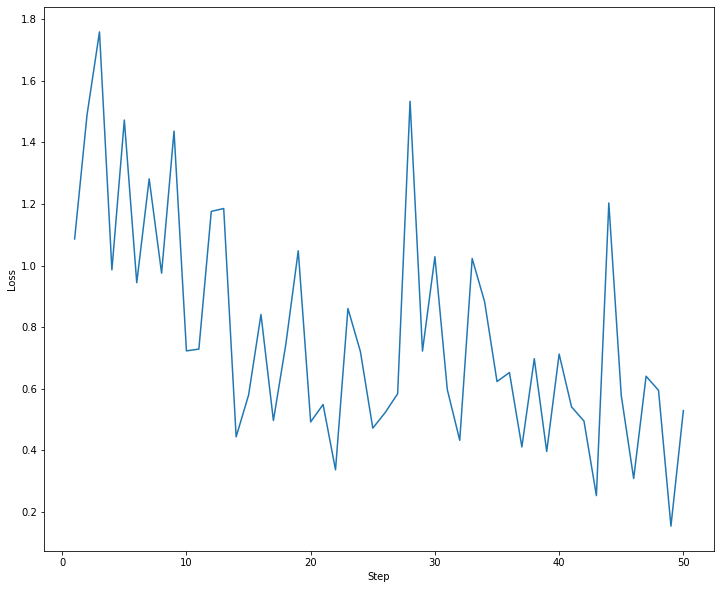

In [47]:
x = (range(1, num_epochs+1))

plt.figure(figsize=(12, 10))

plt.plot(x, loss_values)
plt.xlabel('Step')
plt.ylabel('Loss')

In [48]:
model.eval()

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=800, out_features=400, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=400, out_features=10, bias=True)
  )
)

In [50]:
with torch.no_grad():
    correct = 0
    total = 0
    
    for images, labels in testloader:
        
        outputs = model(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print('Accuracy of the model on 10000 test images: {}%'
             .format(100 * correct / total))

Accuracy of the model on 10000 test images: 76.63%


In [51]:
sample_images, sample_labels = testset[23]

In [52]:
sample_images.shape

torch.Size([3, 32, 32])

In [53]:
sample_image = np.transpose(sample_images, (1, 2, 0))
sample_image.shape

torch.Size([32, 32, 3])

In [55]:
m, M = sample_image.min(), sample_image.max()

In [56]:
sample_image = (1/(abs(m) * M)) * sample_image + 0.5

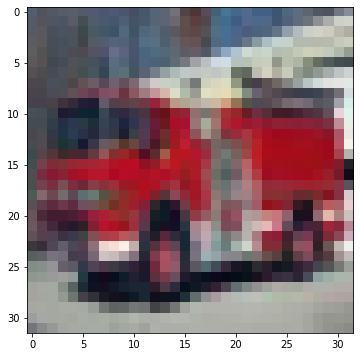

In [57]:
plt.figure(figsize=(6,6))
plt.imshow(sample_image)

In [58]:
test_img, test_label = testset[23]

test_img = test_img.reshape(-1, 3, 32, 32)

In [59]:
out_predicted = model(test_img)
_, predicted = torch.max(out_predicted.data, 1)

In [60]:
print('Actual label: ', get_text_label(test_label))

Actual label:  truck


In [61]:
print('Predicted label: ', get_text_label(predicted.item()))

Predicted label:  truck
